In [2]:
import cv2 as cv
import tensorflow as tf
from tensorflow.keras import models,layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
import matplotlib.pyplot as plt
import os
import imghdr
import numpy as np
import random

#  I: Prepare Data

In [3]:
data_dir = 'Car-Bike-Dataset'
image_exts = ['jpeg','jpg','bmp','png']

In [4]:
name_dir = os.listdir(data_dir)
len_dir = [len(os.listdir(os.path.join(data_dir, i))) for i in name_dir]
print(len_dir)

[1998, 1983]


In [6]:
# xoa cac dinh dang anh khong phu hop
def remove_img(data_dir , image_exts):
    for img in os.listdir(data_dir):
        for image in os.listdir(os.path.join(data_dir , img)):
            image_path = os.path.join(data_dir , img , image)
            try:
                tip = imghdr.what(image_path)
                if tip not in image_exts:
                    print('image not in ext {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e:
                print('Issure not image {}'.format(image_path))
                os.remove(image_path)

In [7]:
remove_img(data_dir, image_exts)

In [8]:
len_dir_last = [len(os.listdir(os.path.join(data_dir, i))) for i in name_dir ]
print(len_dir_last)

[1998, 1983]


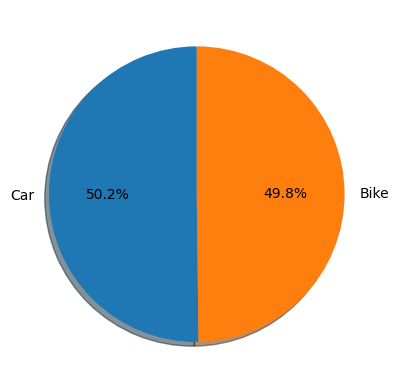

In [51]:
plt.pie(len_dir , labels = name_dir , autopct='%1.1f%%', startangle = 90, shadow = True)
plt.show()

In [11]:
IMAGE_SIZE = 60
BATCH_SIZE = 32 
CHANNELS = 3

In [12]:
Data = tf.keras.preprocessing.image_dataset_from_directory(
'Car-Bike-Dataset',
batch_size = 32,
image_size = (IMAGE_SIZE , IMAGE_SIZE),
shuffle = True
)

Found 3981 files belonging to 2 classes.


2024-03-26 12:18:20.096985: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
print('Number Batch : {}'.format(len(Data)))

Number Batch : 125


In [14]:
class_names = Data.class_names
len_class = len(Data.class_names)
print(class_names)
print(len_class)

['Bike', 'Car']
2


In [15]:
# 1 cho biet kich thuoc cua mot anh va so anh trong 1 bo
# cho thay duoc nhan 0 - 1 duoc gan vao anh
for image_batch, label_batch in Data.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

2024-03-26 12:18:26.862713: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(32, 60, 60, 3)
[0 0 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 0 1]


In [16]:
# ham dung de show anh
def show_img(Data , number_img = [4,3]):
    plt.figure(figsize = (10 ,10))
    for image_batch, label_batch in Data.take(1):
        for i in range(number_img[0]*number_img[1]):
            ax = plt.subplot(number_img[0],number_img[1],i+1)
            plt.imshow(image_batch[i].numpy().astype('uint8'))
            plt.title(class_names[label_batch[i]]+' - label : {}'.format(label_batch[i].numpy()))
            plt.axis('off')

In [17]:
number_img = [4,3]
print(number_img[1]*number_img[0])
print(Data.take(1))

12
<TakeDataset shapes: ((None, 60, 60, 3), (None,)), types: (tf.float32, tf.int32)>


In [18]:
figsize = (10 ,10)

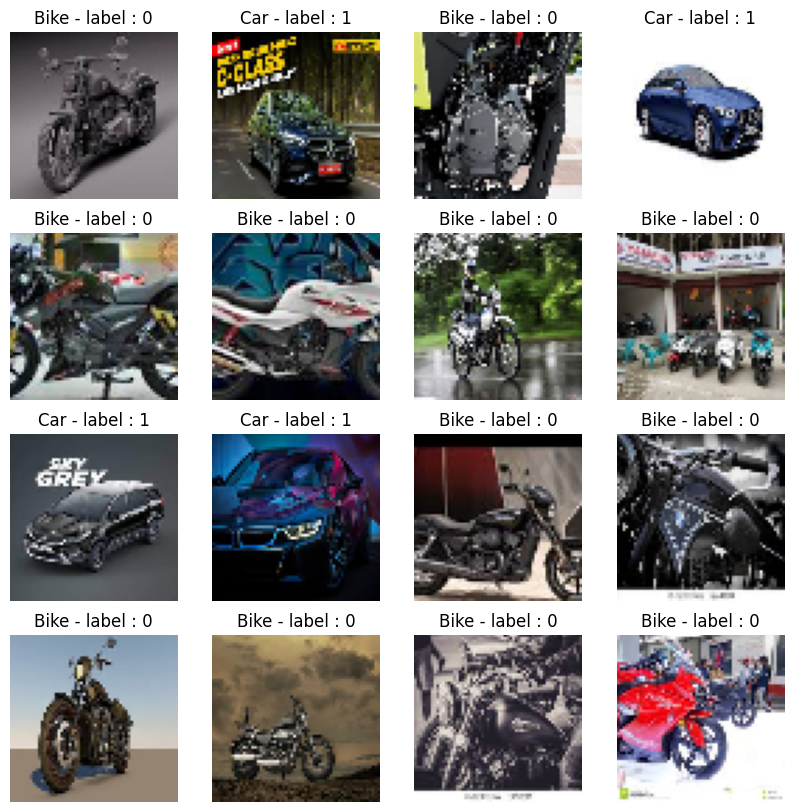

In [19]:
show_img(Data , [4,4])

In [20]:
# chia du lieu thanh 3 phan Train, Val , Test
def setting_data(data , train_scale = 0.8 , val_scale = 0.1, test_scale = 0.1,Shuffle = 1000):
    if Shuffle:
        data = data.shuffle(Shuffle,seed = 20)
    v_train = int(len(data)*0.8)
    v_val = int(len(data)*0.1)
    Train = data.take(v_train)
    Val = data.skip(v_train).take(v_val)
    Test = data.skip(v_train).skip(v_val)
    return Train, Val , Test

In [21]:
Train , Val , Test = setting_data(Data,Shuffle = 40)

In [22]:
print('Number Train : {}'.format(len(Train)))
print('Number Test : {}'.format(len(Val)))
print('Number Test : {}'.format(len(Test)))

Number Train : 100
Number Test : 12
Number Test : 13


In [23]:
Train = Train.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
Val = Val.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
Test = Test.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

###https://www.tutorialspoint.com/how-can-tensorflow-be-used-to-configure-the-dataset-for-performance

# II: Build Model

In [24]:
def create_model(input_shape):
    rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255),
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),])
    model = tf.keras.Sequential([
        rescale,
        #data_augmentation
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        # This is the first convolution
        Conv2D(filters=32,kernel_size=(3,3), activation='relu', input_shape = input_shape),
        MaxPooling2D(pool_size=(2,2)),
        # The second convolution
        Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.25),
        # The third convolution
        Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.25),
        # Flatten the results to feed into a DNN
        Flatten(),
        # 128 neuron hidden layer
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(1,  activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[tf.keras.metrics.BinaryAccuracy()])
    return model

In [25]:
input_shape = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , CHANNELS)
model = create_model(input_shape)
model.build(input_shape = input_shape)

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 60, 60, 3)           0         
_________________________________________________________________
conv2d (Conv2D)              (32, 58, 58, 32)          896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 29, 29, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 27, 27, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 13, 13, 32)          0         
_________________________________________________________________
dropout (Dropout)            (32, 13, 13, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 11, 11, 64)         

In [27]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [28]:
# cp_callbac: train or save model 
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(Train,validation_data=Val, epochs=50 , batch_size = BATCH_SIZE,verbose = 1,callbacks=[cp_callback])

Epoch 1/50


/opt/anaconda3/envs/carandbike/lib/python3.9/site-packages/keras/backend.py:4993: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


100/100 [==============================] - 26s 208ms/step - loss: 0.5089 - binary_accuracy: 0.7331 - val_loss: 0.3391 - val_binary_accuracy: 0.8490

Epoch 00001: saving model to training_1/cp.ckpt
Epoch 2/50
100/100 [==============================] - 13s 134ms/step - loss: 0.3038 - binary_accuracy: 0.8722 - val_loss: 0.2131 - val_binary_accuracy: 0.8958

Epoch 00002: saving model to training_1/cp.ckpt
Epoch 3/50
100/100 [==============================] - 13s 129ms/step - loss: 0.2558 - binary_accuracy: 0.8944 - val_loss: 0.2478 - val_binary_accuracy: 0.8906

Epoch 00003: saving model to training_1/cp.ckpt
Epoch 4/50
100/100 [==============================] - 13s 132ms/step - loss: 0.2473 - binary_accuracy: 0.9062 - val_loss: 0.1678 - val_binary_accuracy: 0.9297

Epoch 00004: saving model to training_1/cp.ckpt
Epoch 5/50
100/100 [==============================] - 11s 106ms/step - loss: 0.2054 - binary_accuracy: 0.9197 - val_loss: 0.1618 - val_binary_accuracy: 0.9375

Epoch 00005: saving

In [34]:
history.history.keys()

##https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

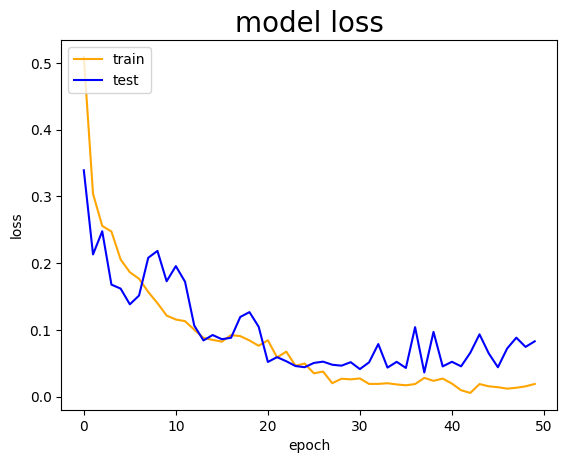

In [35]:
plt.plot(history.history['loss'], color = 'orange',label= 'loss')
plt.plot(history.history['val_loss'], color = 'blue',label= 'val_loss')
plt.title('model loss',fontsize = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

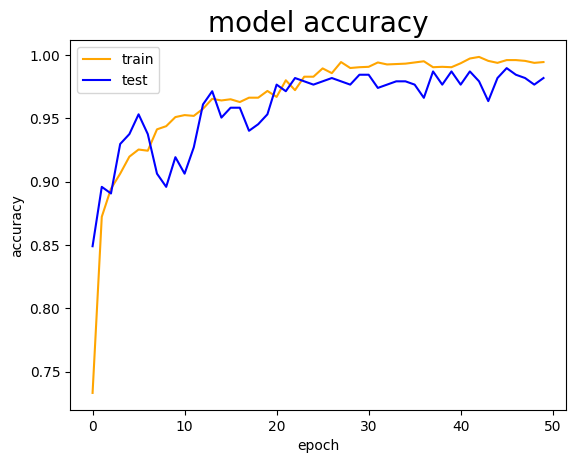

In [36]:
plt.plot(history.history['binary_accuracy'], color = 'orange',label= 'accuracy')
plt.plot(history.history['val_binary_accuracy'], color = 'blue',label= 'val_accuracy')
plt.title('model accuracy',fontsize = 20)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
Test_model = model.evaluate(Test)

13/13 [==============================] - 0s 20ms/step - loss: 0.0999 - binary_accuracy: 0.9808


### Loading model

In [38]:
chack_path = 'training_1'

In [39]:
os.listdir(checkpoint_dir)

['cp.ckpt.data-00000-of-00001',
 'checkpoint',
 '.ipynb_checkpoints',
 'cp.ckpt.index']

In [40]:
latest = tf.train.latest_checkpoint(checkpoint_dir)

In [41]:
new_model = create_model(input_shape)

In [42]:
new_model.load_weights(latest)

In [43]:
def test_img(model , test_ds , number = [3,3] , img_size = 60):
    list_name = os.listdir(test_ds)
    number_img = len(list_name)
    plt.figure(figsize = (15 ,15))
    for img in range(number[0]*number[1]):
        index_img = random.randint(0,number_img-1)
        name_img = list_name[index_img]
        path_img = os.path.join(test_ds , name_img)
        test_image2 = tf.keras.utils.load_img(path_img, target_size=(img_size,img_size))
        test_image2 = np.expand_dims(test_image2, axis=0)
        prediction = new_model.predict(test_image2)
        if prediction > 0.5:
            title = 'Car with accuracy {}'.format(prediction)
        else:
            title = 'Bike with accuracy {}'.format(1- prediction)
        
        plt.subplot(number[0], number[1], img+1)
        plt.imshow(test_image2[0])
        plt.axis('off')
        plt.title(title)

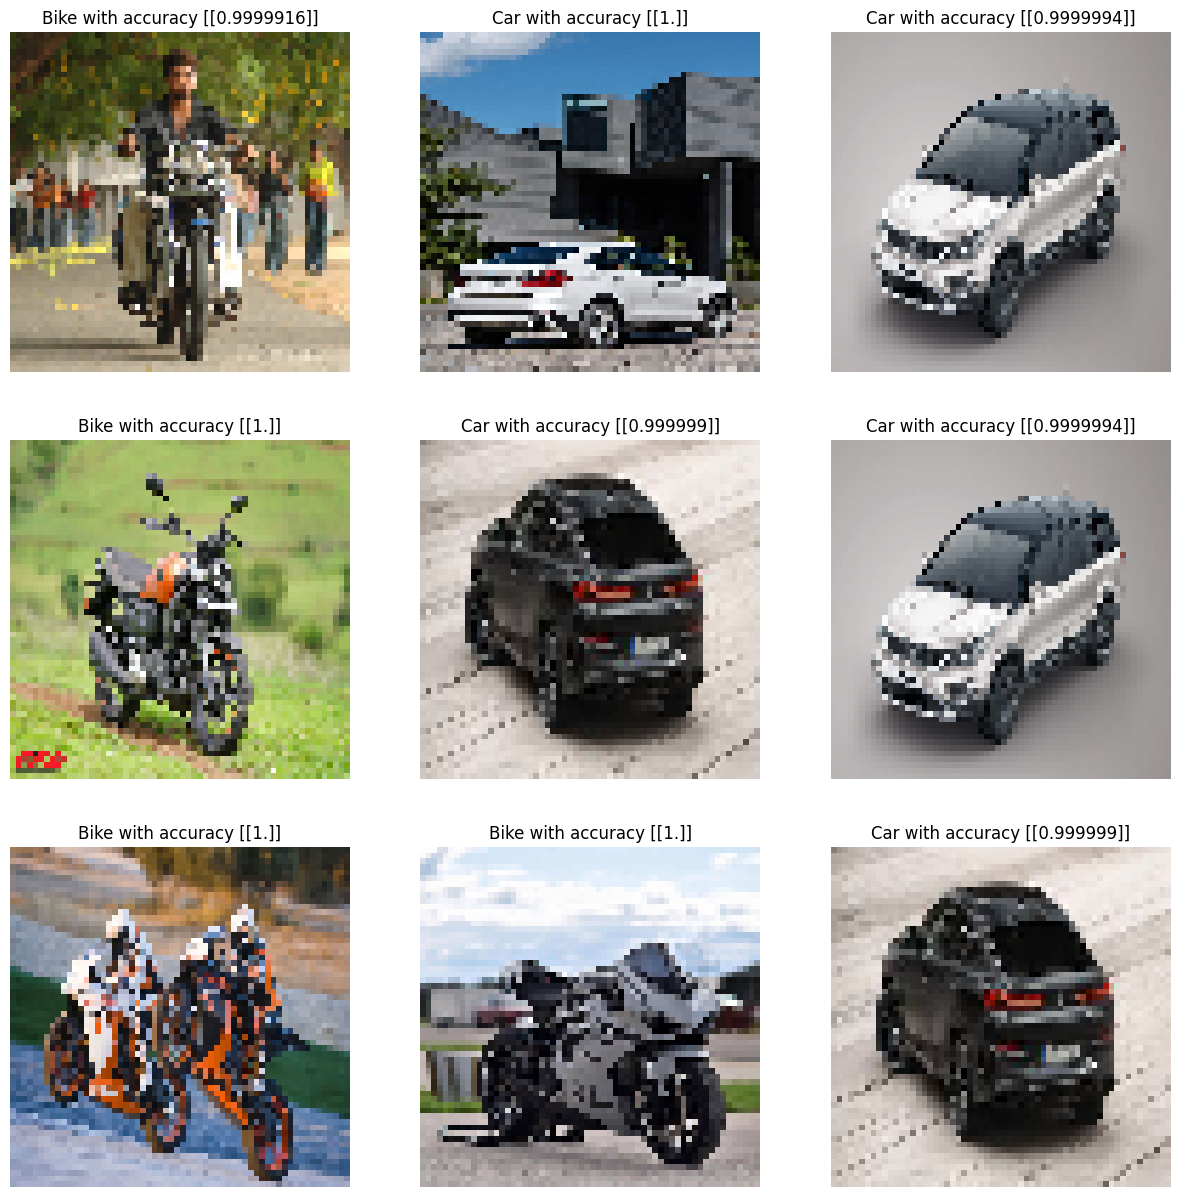

In [44]:
dir_test_model = 'Test'
test_img(new_model , dir_test_model , [3,3],60)